# KV Cache传输与重计算的对比

在推理任务中，采用池化KV Cache可以显著加速Prefill阶段，有效降低首Token延迟（TTFT）。那么，KV Cache的传输是否一定比重新计算更快？这与哪些因素有关？本例将通过理论计算，带您找到答案。


内容：
* MLA模型的对比计算；
* GQA模型的对比计算。


相关文章：

- [KV cache用池化的数据会比重算更快吗？](https://www.zhihu.com/question/1954115162412942829/answer/1964780161137381481)

- [vLLM的prefix cache为何零开销](https://zhuanlan.zhihu.com/p/1896927732027335111)


Author: kaiyuan

Email: kyxie@zju.edu.cn

## 1 计算思路与假设

KV cache池化方案更快时，满足如下朴素的不等式：

$$accessData / bandwidth + \mu  \leq calcData / Flops$$

其中bandwith为传输实际带宽，或者说数据从存储介质搬移到GPU的最小带宽位置，Flops为GPU的算力*效率。u表示软件模块之间协同产生的时延；

对比时的假设：
- 传输与计算之间是串行的（并行方式时间不好估计）；
- 计算仅考虑Attenion部分；
- 带宽考虑短板效应以最慢速度计算，传输效率取0.5~0.7；
- 计算以FP16格式算力为准，mfu取值0.4~0.5；
- 忽略软件模块产生的时延u；

实验涉及的关键参数定义如下：
- context length: 指代Prefill阶段需要处理的完整上下文长度。
- cache_len: 指代已缓存并可复用的前缀（Prefix）长度。
- seq_len: 指代当前需要执行Attention计算的新增序列长度。

有context_length = cache_len + seq_len，计算过程中：

- 仅考虑传输（Transfer）时，seq_len=1；
- 仅考虑重计算（Recompute）时，cache_len=0；


## 2 算力密集型模型

模型对硬件的计算能力要求高，显存/访存要求低。比如MLA模型，这里以DeepSeekV3为例计算。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# MLA的相关参数，参考DeepSeekV3参数
bs = 1
heads = 128
qk_head_dim = 128
kv_lora_rank = 512
h_dim = 7168
q_lora_rank = 1536
qk_rope_head_dim = 64
v_head_dim = 128
n_heads = v_head_dim
causal_mask_cof = 2 # casual mask是否启用 开启等于2，关闭等于1
n_shared_experts = 1
n_routed_experts = 256
moe_inter_dim = 2048
n_activated_experts = 8

在Prefill阶段，MLA采用MHA模式(非吸收矩阵计算)

相关概念参考：[超细图解MLA计算流&吸收矩阵对比分析](https://zhuanlan.zhihu.com/p/1948769945132470860)


In [ ]:
# 非吸收矩阵计算:
def calc_mla_non_absorb_flops(seq_len, cache_len=0):
    q_down_proj = 2 * bs * seq_len * h_dim * q_lora_rank
    q_up_proj = 2 * bs * seq_len * q_lora_rank * heads * (qk_head_dim + qk_rope_head_dim)
    q_linear = q_down_proj + q_up_proj

    kv_down_proj = 2 * bs * seq_len * h_dim * (kv_lora_rank + qk_rope_head_dim)
    kv_up_proj = 2 * bs * heads * (seq_len + cache_len) * kv_lora_rank * (qk_head_dim + v_head_dim)
    kv_linear = kv_down_proj + kv_up_proj

    kv_scores = 2 * bs * heads * seq_len * (seq_len + cache_len) * (qk_head_dim + qk_rope_head_dim) / causal_mask_cof
    qkv = 2 * bs * heads * seq_len * (seq_len + cache_len) * v_head_dim / causal_mask_cof
    out = 2 * bs * seq_len * n_heads * v_head_dim * h_dim
    attention = kv_scores + qkv
    mla_non_absorb_flops = attention + kv_linear + q_linear + out
    return mla_non_absorb_flops, q_linear, kv_linear, attention, out

def calc_moe(seq_len):
    linear_layer_flops = 2 * 3 * bs * seq_len * h_dim * moe_inter_dim
    route_flops = 2 *  bs * seq_len * h_dim * n_routed_experts
    moe_layer_flops = linear_layer_flops * (n_shared_experts + n_activated_experts) + route_flops
    return moe_layer_flops

def calc_mla_kv(seq_len, type_factor=2):
  # GB: (1024*1024*1024)
  return type_factor * bs * seq_len * (kv_lora_rank + qk_rope_head_dim) / (1024*1024*1024)

def convert_flops(flops, cof=1024 * 1024 * 1024 * 1024):
    return flops / cof

In [ ]:
# 绘图函数
def plot_data(x, base_data, transfer_kv_data, recompute_kv_data, plot_extra=10, title = "MLA Prefill", xlable='context length(seq_len + cache_len)'):

  # 创建图形
  plt.figure(figsize=(8, 4))
  max_y = 0
  # 绘制多条折线
  if base_data is not None:
    plt.plot(x, base_data, label='None', marker='o')
    max_y = max(max_y, max(base_data))
  if transfer_kv_data is not None:
    plt.plot(x, transfer_kv_data, label='Transfer KV cache', marker='o')
    max_y = max(max_y, max(transfer_kv_data))
  if recompute_kv_data is not None:
    plt.plot(x, recompute_kv_data, label='Recompute KV cache', marker='s')
    max_y = max(max_y, max(recompute_kv_data))

  plt.ylim(0, max_y + plot_extra)


  # 添加标题和标签
  plt.title(title)
  plt.xlabel(xlable)
  plt.ylabel('Elapsed Time/ms')

  # 添加图例
  plt.legend()

  # 显示网格
  plt.grid(True, linestyle='--', alpha=0.7)

  # 显示图形
  plt.show()

In [ ]:
# MLA的数据分析函数定义：
def analyze_mla(mfu, net_cof, device_tflops):
  actual_tflops = device_tflops * mfu
  bw_list = [0.5, 1, 10] # 带宽取值，GB/s
  for bw in bw_list:
    net_bw = bw * net_cof  #GB/s

    x = []
    mla_non_absorb_flops_recompute_data = []
    transfer_time_data = []

    for i in range(0, 18000, 1000):
      mla_non_absorb_flops_with_cache, _, _, attention, *_ = calc_mla_non_absorb_flops(1, i)
      mla_non_absorb_flops_baseline, *_ = calc_mla_non_absorb_flops(i, 0)
      diff_flops = mla_non_absorb_flops_baseline - mla_non_absorb_flops_with_cache
      transfer_time_data.append((calc_mla_kv(i) / net_bw) * 1000) # ms

      # moe = calc_moe(i)
      x.append(i)
      mla_non_absorb_flops_recompute_data.append(1000 * convert_flops(diff_flops)/actual_tflops)


    plot_data(x, None, transfer_time_data, mla_non_absorb_flops_recompute_data, plot_extra=0, title = f"MLA Prefill (bw={bw}GB/s)")

### MLA数据曲线绘制-H100

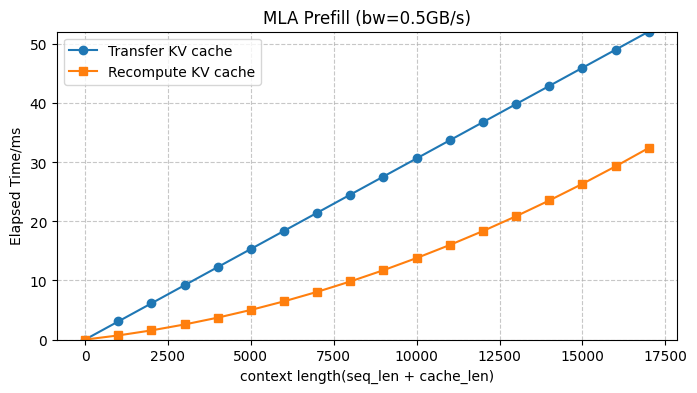

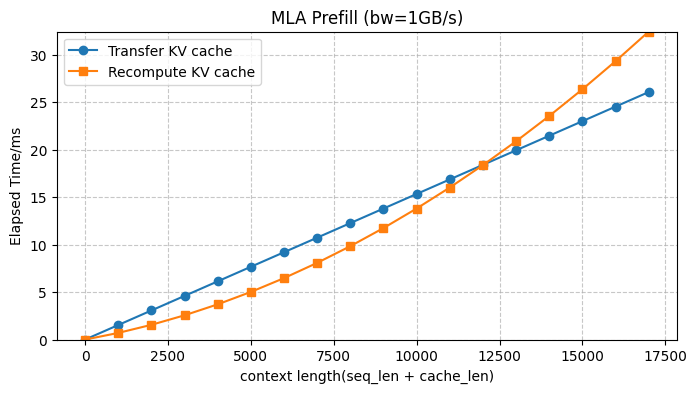

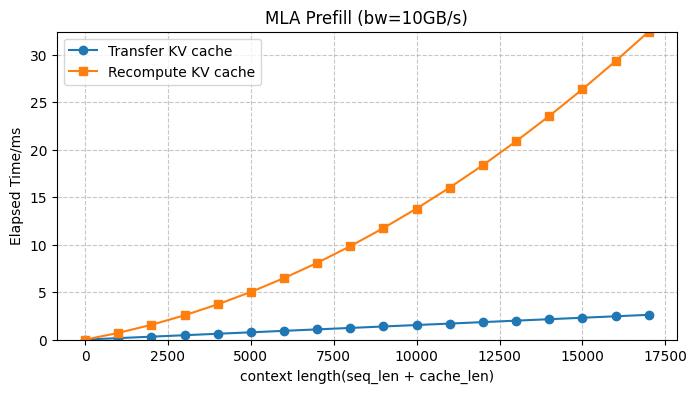

In [ ]:
"""
FP16BF16算力
  GPU: H20 148 H100/800 989
  NPU: A2/A3默认单die都是400T A2 354T

"""

device_tflops = 989

net_cof = 0.7 # 网络传输系数
mfu = 0.5   # 0.5 单纯只考虑attention部分可能MFU更高

analyze_mla(mfu, net_cof, device_tflops)

### MLA数据曲线绘制:H20

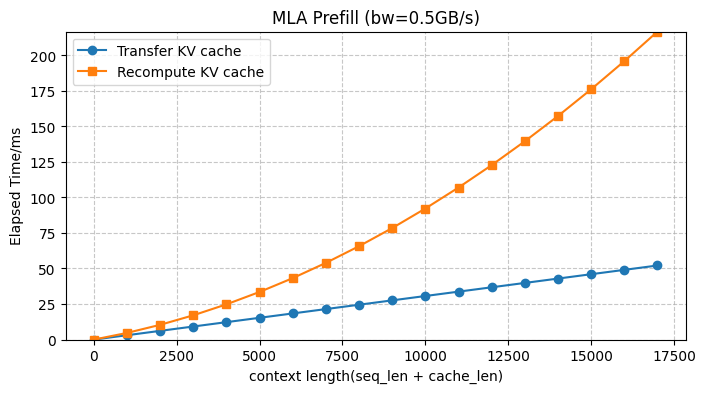

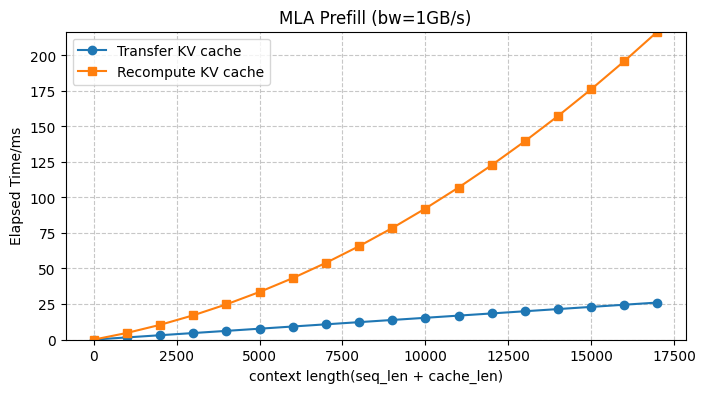

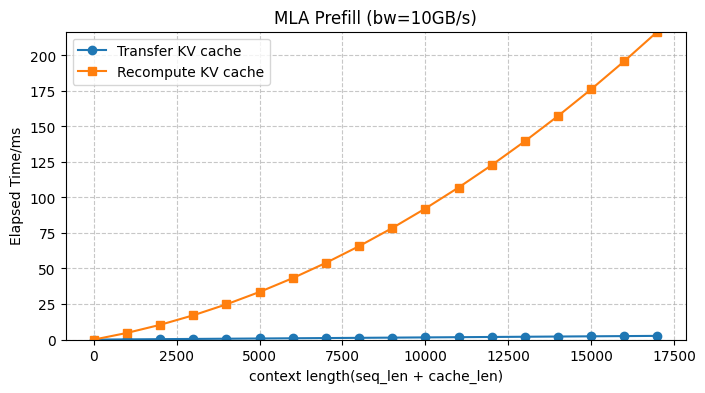

In [ ]:
"""
FP16BF16算力
  GPU: H20 148 H100/800 989
  NPU: A2/A3默认单die都是400T A2 354T

"""

device_tflops = 148

net_cof = 0.7 # 网络传输系数
mfu = 0.5   # 0.5 单纯只考虑attention部分可能MFU更高

analyze_mla(mfu, net_cof, device_tflops)

### MLA数据曲线绘制:NPU 910C

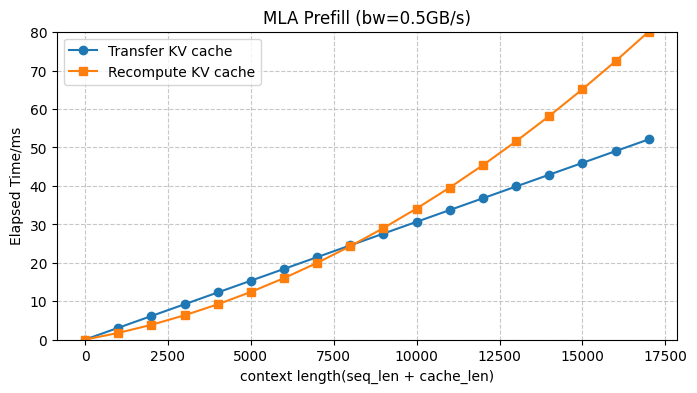

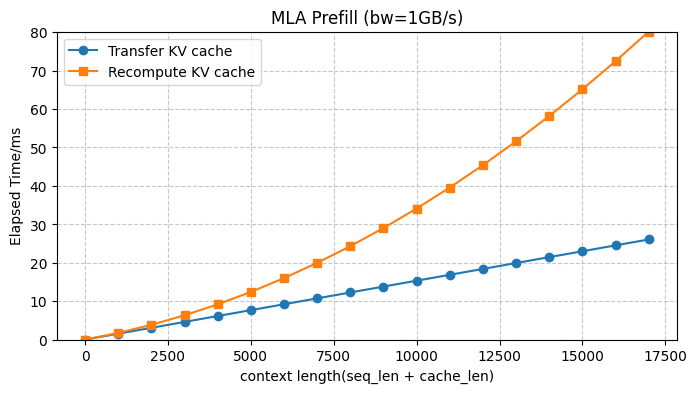

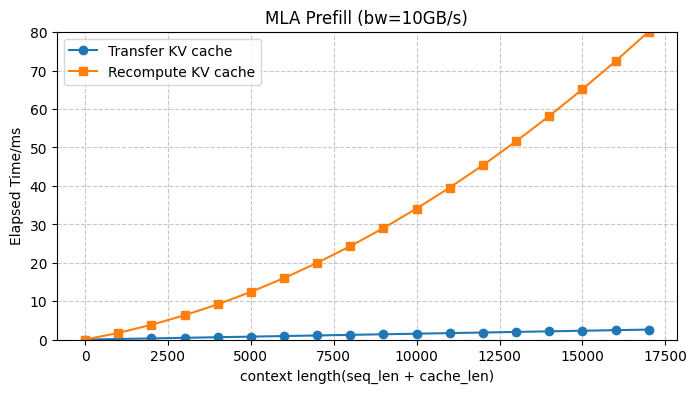

In [ ]:
"""
FP16BF16算力
  GPU: H20 148 H100/800 989
  NPU: A2/A3默认单die都是400T A2 354T

"""

device_tflops = 400

net_cof = 0.7 # 网络传输系数
mfu = 0.5   # 0.5 单纯只考虑attention部分可能MFU更高

analyze_mla(mfu, net_cof, device_tflops)

## 2 存储密集型模型

GQA/MHA的KV cache大小相比同规模的MLA更大，传输时间也更长，这里以GQA模型为例进行对比。

模型选取Qwen3 235B参数

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# GQA参数
bs = 1
heads = 64 # num_attention_heads
num_key_value_heads = 4 # key value 32B:8 235B: "num_key_value_heads": 4,
h_dim = 4096  # hidden_size 32B: 5120  235B: 4096
head_dim = 128

def convert_flops(flops, cof=1024 * 1024 * 1024 * 1024):
    return flops / cof

# GQA计算函数定义
def calc_gqa_flops(seq_len, cache_len=0):
    q_linear = 2 * bs * seq_len * h_dim * head_dim * heads
    kv_linear = 2 * 2 * bs * (seq_len + cache_len) * h_dim * head_dim * num_key_value_heads
    kv_scores = 2 * bs * heads * seq_len * (seq_len + cache_len) * head_dim / causal_mask_cof
    qkv = 2 * bs * heads * seq_len * (seq_len + cache_len) * head_dim / causal_mask_cof
    out = 2 * bs * seq_len * heads * head_dim * h_dim
    attention = kv_scores + qkv
    mla_non_absorb_flops = attention + kv_linear + q_linear + out
    return mla_non_absorb_flops, q_linear, kv_linear, attention, out

def calc_gqa_kv_mem(seq_len, type_factor=2):
    return 2 * type_factor * seq_len * num_key_value_heads * head_dim / (1024*1024*1024)



In [ ]:
def analyze_gqa(mfu, net_cof, device_tflops):
  actual_tflops = device_tflops * mfu
  bw_list = [0.5, 1,  10] # 带宽取值，GB/s
  for bw in bw_list:
    net_bw = bw * net_cof  #GB/s

    x = []
    gqa_flops_data = []

    transfer_time_data = []

    for i in range(0, 15000, 700):
      gqa_flops_with_cache, _, _, attention, *_ = calc_gqa_flops(1, i)
      gqa_flops_baseline, *_ = calc_gqa_flops(i, 0)
      diff_flops = gqa_flops_baseline - gqa_flops_with_cache
      transfer_time_data.append((calc_gqa_kv_mem(i) / net_bw) * 1000) # ms

      # moe = calc_moe(i)
      x.append(i)
      gqa_flops_data.append(1000 * convert_flops(gqa_flops_baseline)/actual_tflops)


    plot_data(x, None, transfer_time_data, gqa_flops_data, plot_extra=0, title = f"GQA Prefill (bw={bw}GB/s)")

### GQA数据曲线绘制: H100

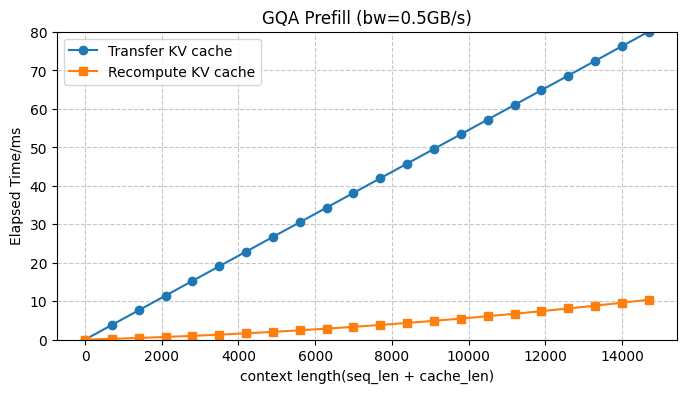

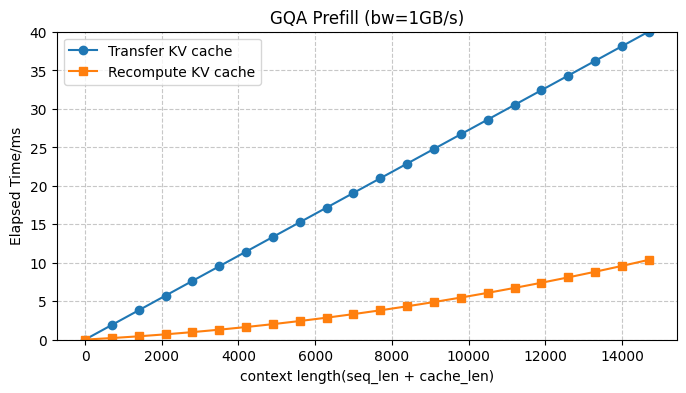

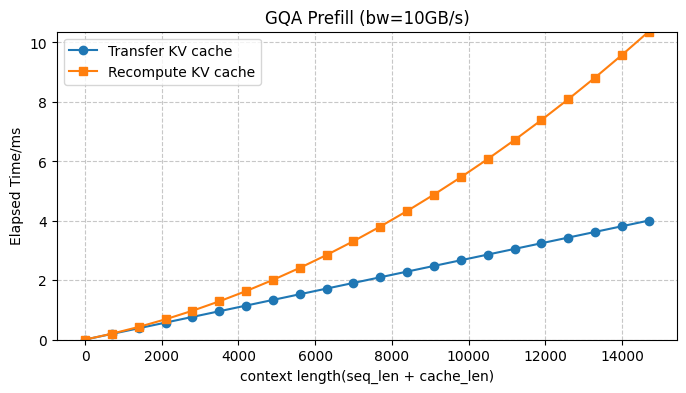

In [ ]:
"""
FP16BF16算力
  GPU: H20 148 H100/800 989
  NPU: A2/A3默认单die都是400T A2 354T

"""

device_tflops = 989

net_cof = 0.7 # 网络传输系数
mfu = 0.5   # 0.5 单纯只考虑attention部分可能MFU更高

analyze_gqa(mfu, net_cof, device_tflops)

### GQA数据曲线绘制: NPU 910C

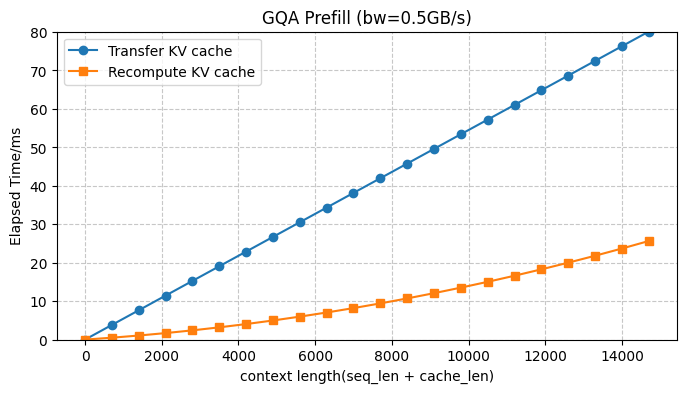

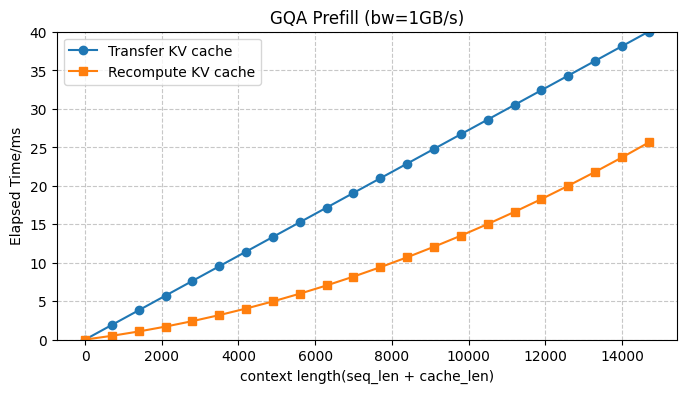

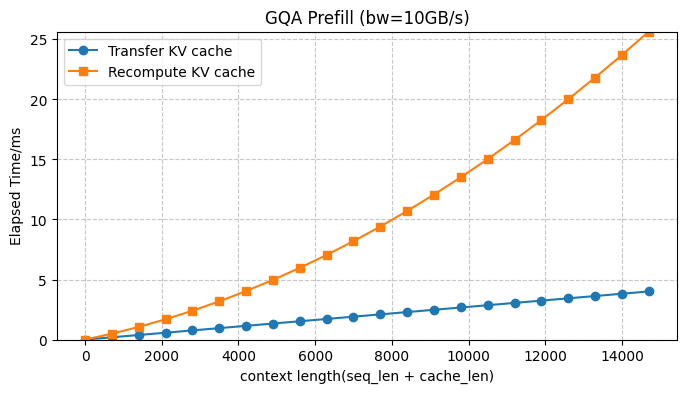

In [ ]:
"""
FP16BF16算力
  GPU: H20 148 H100/800 989
  NPU: A2/A3默认单die都是400T A2 354T

"""

device_tflops = 400

net_cof = 0.7 # 网络传输系数
mfu = 0.5   # 0.5 单纯只考虑attention部分可能MFU更高

analyze_gqa(mfu, net_cof, device_tflops)